# Višeklasna klasifikacija korišćenjem neuronskih mreža

Zadatak:
* dizajnirati i natrenirati klasfikator koji slici cifre pridružuje cifru koja se na njoj nalazi.
* skup podataka: MNIST skup slika cifara
* dizajn resenja: koristićti neuronsku mrežu sa propagacijom unapred

Disclaimer: već na narednim vežbama, u istom zadatku klasifikacije slika, uvešćemo konvolutivne neuronske mreže koje predstavlju prirodniji izbor za resavanje ovog problema.

In [1]:
import sys
sys.path.append('..')  

import matftorch

In [ ]:
RANDOM_STATE = 1219
N_EPOCHS = 50
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_TEST = 1000
np.random.seed(RANDOM_STATE)

## Dataset

MNIST je skup podataka koji sadrži slike rukom pisanih cifara. Slika ima ukupno 70.000 od čega se obično 60.000 slika koristi za treniranje, a preostalih 10.000 za testiranje. Sve slike u skupu podataka su dimenzije 28px x 28px i u crno-belom su modu. Više o MNIST skupu podataka, kao i rezultatima dobijenim prvim algoritmima mašinskog učenja, možete pročitati [ovde](http://yann.lecun.com/exdb/mnist/).

In [ ]:
from torchvision import datasets, transforms
from torch import utils

norm_mean = 0
norm_stddev = 1

train_loader = utils.data.DataLoader(
    datasets.MNIST('/files/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_stddev,))
                       ])),
    batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_loader = utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_stddev,))
                       ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True)

In [ ]:
print(len(train_loader.dataset), len(test_loader.dataset))

60000 10000


In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

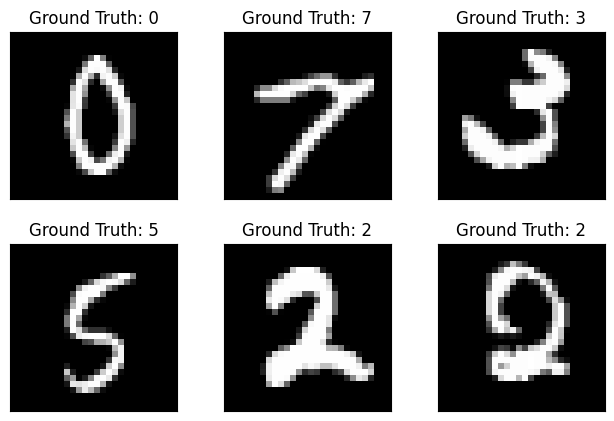

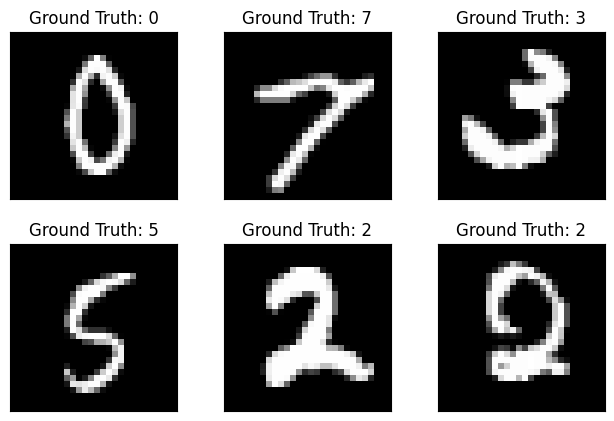

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
# for example, print 7-th instance
i = 5
print(example_data[i].shape, example_data[i][0].shape, example_data[i][0][0], example_targets[i])

torch.Size([1, 28, 28]) torch.Size([28, 28]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]) tensor(2)


## Dizjan Neuronske Mreze


Na slici je prikazana arhitekture mreže koju ćemo kreirati.

<img src="assets/mlp_mnist.png" />

#### Ulazni sloj

Ulaz u mrežu je "ispravljena" slika dimenzije 784 piksela.

<img src="assets/mnist-input.png" />


#### Skriveni slojevi

Mreža ima dva skrivena sloja, jedan dimenzije 128 neurona i drugi dimenzije 64 neurona. Oba sloja kao aktivaciju koriste *ReLu* funkciju.



#### Izlazni sloj

Izlazni sloj mreže ima 10 neurona. Svaki od njih odgovara jednoj od cifara od 0 do 9. Ideja je da vrednosti izlaza predstavljaju verovatnoće pripadanja odgovarajućoj klasi cifara. Preciznije, ako se za ulaz *img* koji predstavlja sliku dobija izlaz oblika $(v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9)$ rezultat tj. klasa pripadanja će biti ona vrednost $i$ za koju je $v_i$ maksimalno. Na primer, ako $v_4$ ima najveću vrednost, onda zaključujemo da slika *img*  predstavlja broj 4.

Zato ćemo u poslednjem sloju mreže kao aktivacionu funkciju iskoristiti funkciju mekog maksimuma (engl. softmax) koja vrednost $v_i$ mapira u vrednost $\frac{e^{v_i}}{\sum_j{e^{v_j}}}$

In [ ]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()  # Convert 2D image to 1D tensor
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

## Trening Neuronske Mreze

U zadacima višeklasne klasifikacije, uz aktivaciju mekog maksimuma u zadanjem sloju, obično se kao funkcija gubitka koristi `kategorička unakrsna entropija` (engl. categorical crossentropy). Ona predstavlja uopštenje binarne unakrsne entropije i računa se po formuli $-\sum_i{y_i \cdot log(\hat{y_i})}$ u kojoj $\hat{y_i}$ predstavlja predikciju mreže za instacu $i$, a $y_i$ njenu stvarnu vrednost.

Kao optimizator ćemo koristiti `Adam`.

Pratićemo tačnost kao relevantnu metriku za ocenu klasifikacije.

In [ ]:
img_size = 28
number_of_classes = 10

model = MNISTClassifier(img_size, number_of_classes)
matftorch.bind_gpu(model)
print(model)
print(matftorch.count_parameters(model))

MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
109386


Epoch [1/50], Loss: 1.9725, Accuracy: 0.5747
Epoch [2/50], Loss: 1.6482, Accuracy: 0.8300
Epoch [3/50], Loss: 1.6239, Accuracy: 0.8458
Epoch [4/50], Loss: 1.6145, Accuracy: 0.8523
Epoch [5/50], Loss: 1.6084, Accuracy: 0.8577
Epoch [6/50], Loss: 1.5994, Accuracy: 0.8671
Epoch [7/50], Loss: 1.5455, Accuracy: 0.9252
Epoch [8/50], Loss: 1.5319, Accuracy: 0.9364
Epoch [9/50], Loss: 1.5254, Accuracy: 0.9423
Epoch [10/50], Loss: 1.5195, Accuracy: 0.9473
Epoch [11/50], Loss: 1.5149, Accuracy: 0.9518
Epoch [12/50], Loss: 1.5113, Accuracy: 0.9547
Epoch [13/50], Loss: 1.5083, Accuracy: 0.9572
Epoch [14/50], Loss: 1.5065, Accuracy: 0.9589
Epoch [15/50], Loss: 1.5033, Accuracy: 0.9622
Epoch [16/50], Loss: 1.5011, Accuracy: 0.9644
Epoch [17/50], Loss: 1.4992, Accuracy: 0.9660
Epoch [18/50], Loss: 1.4972, Accuracy: 0.9677
Epoch [19/50], Loss: 1.4956, Accuracy: 0.9691
Epoch [20/50], Loss: 1.4944, Accuracy: 0.9702
Epoch [21/50], Loss: 1.4931, Accuracy: 0.9715
Epoch [22/50], Loss: 1.4918, Accuracy: 0.97

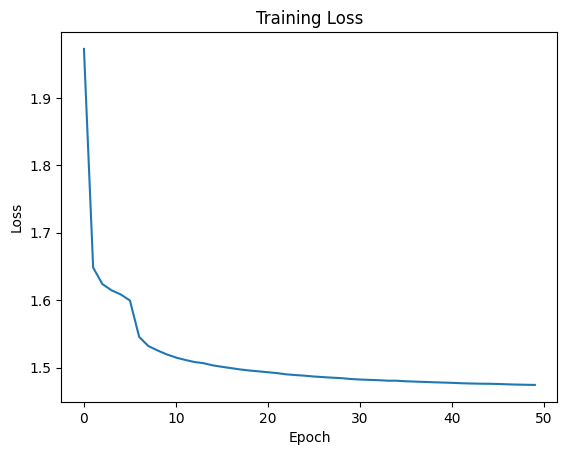

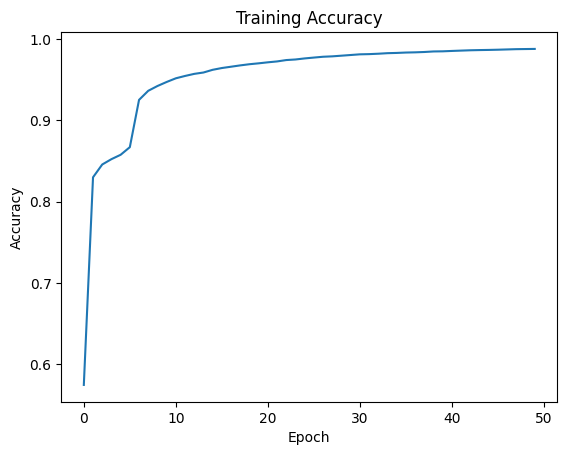

CPU times: user 10min 52s, sys: 1.99 s, total: 10min 54s
Wall time: 11min 7s


In [ ]:
%%time

import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = matftorch.train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, multiclass=True)
matftorch.plot_classification(losses, accuracies)

Train Set: Loss: 1.4737, Accuracy: 0.9882


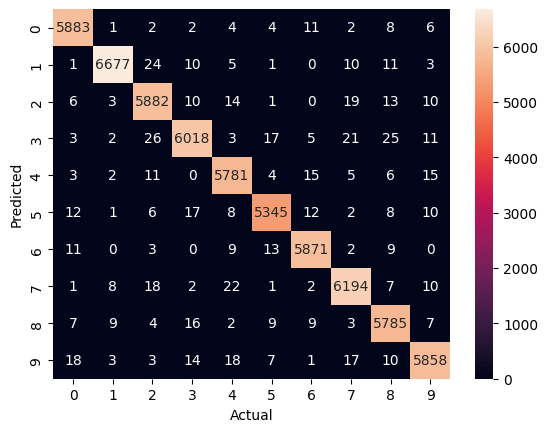

In [ ]:
train_loss, train_accuracy = matftorch.evaluate_classification(model, criterion, train_loader, True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

Test Set: Loss: 1.4885, Accuracy: 0.9742


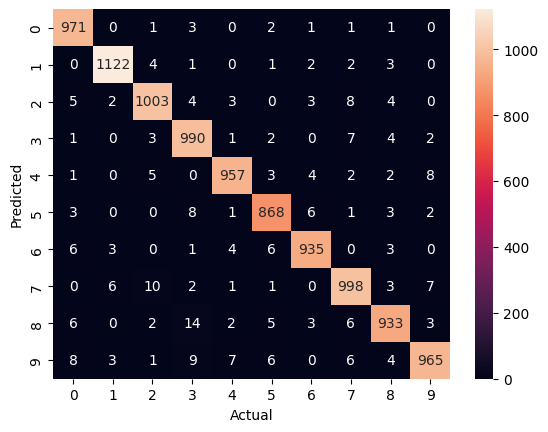

In [ ]:
test_loss, test_accuracy = matftorch.evaluate_classification(model, criterion, test_loader, True)
print(f'Test Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + Validation Split

In [ ]:
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
data_dir = '/files/'
norm_mean = 0
norm_stddev = 1
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((norm_mean,), (norm_stddev,))
])

valid_size = 0.2
shuffle = True
num_workers = 1
pin_memory = True

In [ ]:
train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
valid_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=train_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
  np.random.seed(RANDOM_STATE)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, sampler=None,
                                           num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader, multiclass=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    device = get_device()

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if multiclass:
              predicted = torch.argmax(outputs, dim=1)
            else:
              predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs.squeeze(), val_labels)
                    val_running_loss += val_loss.item()

                    if multiclass:
                      val_predicted = torch.argmax(val_outputs, dim=1)
                    else:
                      val_predicted = (val_outputs > 0.5).float()
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted.squeeze() == val_labels).sum().item()

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_correct / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

import matplotlib.pyplot as plt

def plot_classification(train_loss, train_accuracy, val_loss, val_accuracy):
    number_of_epochs = len(train_loss)
    epochs = range(1, number_of_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Training Loss
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')

    plt.legend()

    # Plotting Training Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
matftorch.bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 50

train_losses, train_accuracies, val_losses, val_accuracies = matftorch.train_classification(model, criterion, optimizer, epochs, train_loader, valid_loader, True)

Epoch [1/50], Train Loss: 2.0424, Train Accuracy: 0.5557
Epoch [1/50], Validation Loss: 1.7393, Validation Accuracy: 0.7712
Epoch [2/50], Train Loss: 1.6419, Train Accuracy: 0.8603
Epoch [2/50], Validation Loss: 1.5897, Validation Accuracy: 0.8946
Epoch [3/50], Train Loss: 1.5743, Train Accuracy: 0.9045
Epoch [3/50], Validation Loss: 1.5625, Validation Accuracy: 0.9129
Epoch [4/50], Train Loss: 1.5539, Train Accuracy: 0.9197
Epoch [4/50], Validation Loss: 1.5483, Validation Accuracy: 0.9229
Epoch [5/50], Train Loss: 1.5426, Train Accuracy: 0.9275
Epoch [5/50], Validation Loss: 1.5401, Validation Accuracy: 0.9287
Epoch [6/50], Train Loss: 1.5341, Train Accuracy: 0.9348
Epoch [6/50], Validation Loss: 1.5348, Validation Accuracy: 0.9327
Epoch [7/50], Train Loss: 1.5282, Train Accuracy: 0.9405
Epoch [7/50], Validation Loss: 1.5306, Validation Accuracy: 0.9360
Epoch [8/50], Train Loss: 1.5228, Train Accuracy: 0.9454
Epoch [8/50], Validation Loss: 1.5266, Validation Accuracy: 0.9397
Epoch [9

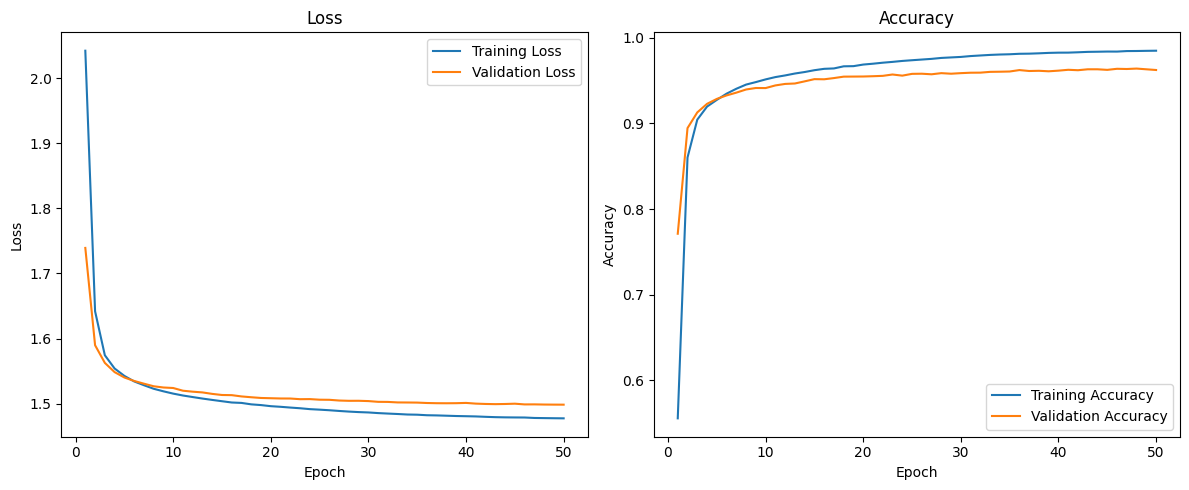

In [ ]:
matftorch.plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Train Set: Loss: 1.4771, Accuracy: 0.9851


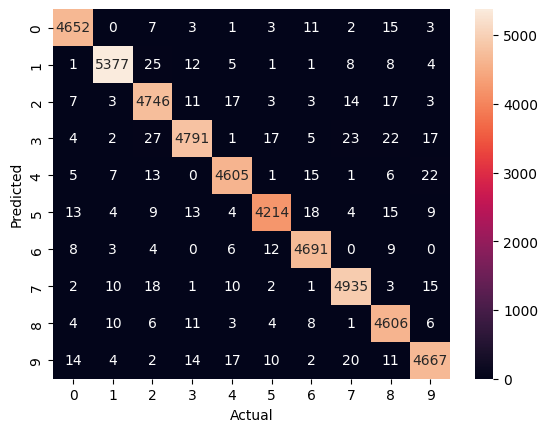

In [ ]:
train_loss, train_accuracy = matftorch.evaluate_classification(model, criterion, train_loader, True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

Train Set: Loss: 1.4960, Accuracy: 0.9661


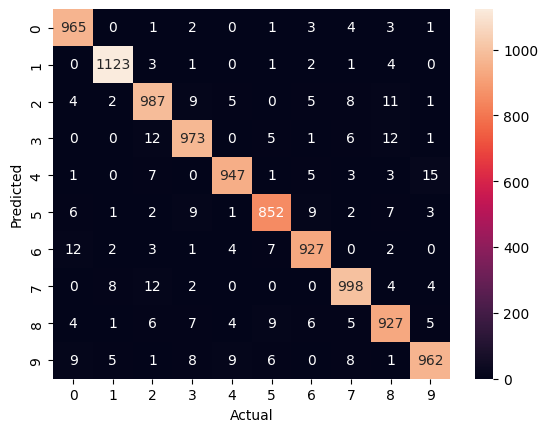

In [ ]:
test_loss, test_accuracy = matftorch.evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + L2

U opštem slučaju, prilikom analize tačnosti klasifikacije možemo se voditi zaključcima prikazanim na slici. <img src='assets/train_val_accuracy.png'>

Jedan način da se doda regularizacija modelu je uz korišćenje L2 regularizacije: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

In [ ]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
matftorch.bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=5e-4)

train_losses, train_accuracies, val_losses, val_accuracies = matftorch.train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, valid_loader, True)

Epoch [1/50], Train Loss: 2.0533, Train Accuracy: 0.5358
Epoch [1/50], Validation Loss: 1.7855, Validation Accuracy: 0.7216
Epoch [2/50], Train Loss: 1.6936, Train Accuracy: 0.8028
Epoch [2/50], Validation Loss: 1.6109, Validation Accuracy: 0.8855
Epoch [3/50], Train Loss: 1.5871, Train Accuracy: 0.8995
Epoch [3/50], Validation Loss: 1.5724, Validation Accuracy: 0.9087
Epoch [4/50], Train Loss: 1.5644, Train Accuracy: 0.9152
Epoch [4/50], Validation Loss: 1.5591, Validation Accuracy: 0.9182
Epoch [5/50], Train Loss: 1.5539, Train Accuracy: 0.9230
Epoch [5/50], Validation Loss: 1.5526, Validation Accuracy: 0.9217
Epoch [6/50], Train Loss: 1.5468, Train Accuracy: 0.9287
Epoch [6/50], Validation Loss: 1.5487, Validation Accuracy: 0.9267
Epoch [7/50], Train Loss: 1.5421, Train Accuracy: 0.9330
Epoch [7/50], Validation Loss: 1.5439, Validation Accuracy: 0.9294
Epoch [8/50], Train Loss: 1.5383, Train Accuracy: 0.9354
Epoch [8/50], Validation Loss: 1.5412, Validation Accuracy: 0.9309
Epoch [9

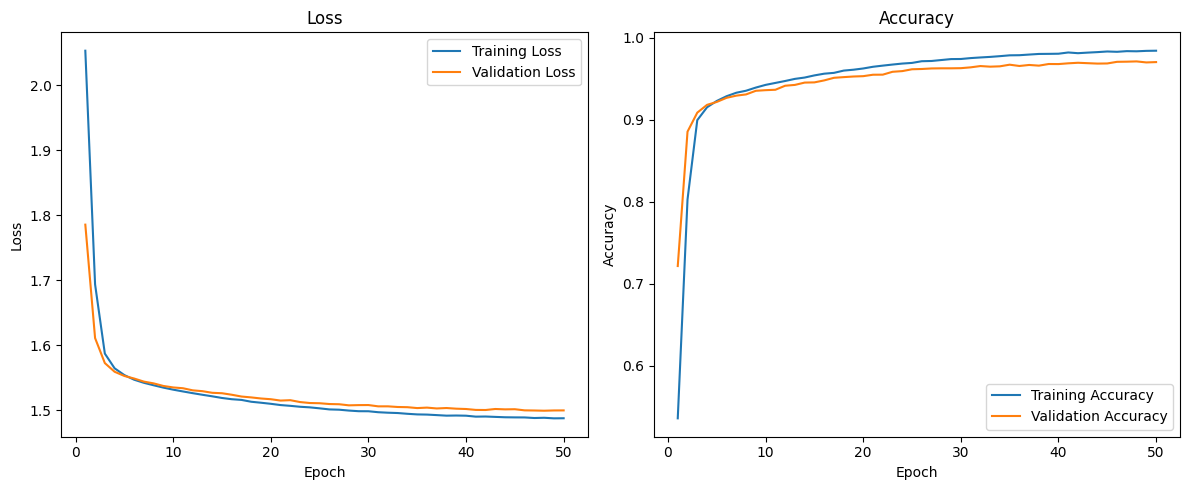

In [ ]:
matftorch.plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Kao što možemo videti sada se situacija značajno popravila i naše krive se lepo prate.

Train Set: Loss: 1.4975, Accuracy: 0.9728


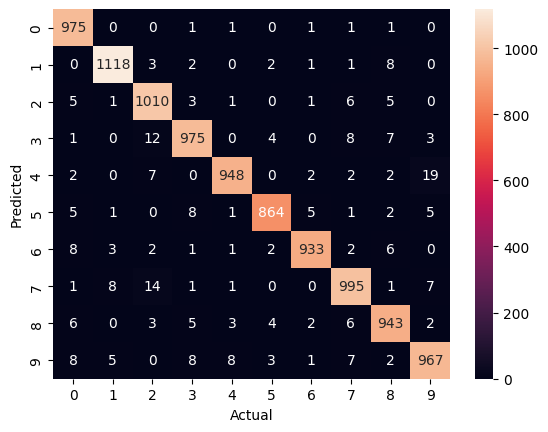

In [ ]:
test_loss, test_accuracy = matftorch.evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

## Trening Neuronske Mreze + Dropout

Zbog velikog broja parametara, regularizacije se gotovo pa neizostavno koriste u procesu obučavanja neuronskih mreža. Još jedna tehnika regularizacije je takozvana `dropout` regularizacija. Korišćenjem `dropout` regularizacije isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar `rate` je verovatnoća isključivanja pojedinačnih neurona.
<img src='assets/dropout.png'>

In [ ]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes, dropout_prob=0.5):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # First dropout layer
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Second dropout layer
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)  # Apply dropout after activation
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)  # Apply dropout after activation
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [ ]:
%%time

model = MNISTClassifier(img_size, number_of_classes)
matftorch.bind_gpu(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses, train_accuracies, val_losses, val_accuracies = matftorch.train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, valid_loader, True)

Epoch [1/50], Train Loss: 2.1042, Train Accuracy: 0.4289
Epoch [1/50], Validation Loss: 1.8275, Validation Accuracy: 0.6468
Epoch [2/50], Train Loss: 1.8043, Train Accuracy: 0.6857
Epoch [2/50], Validation Loss: 1.6486, Validation Accuracy: 0.8387
Epoch [3/50], Train Loss: 1.6826, Train Accuracy: 0.8084
Epoch [3/50], Validation Loss: 1.5825, Validation Accuracy: 0.8922
Epoch [4/50], Train Loss: 1.6311, Train Accuracy: 0.8509
Epoch [4/50], Validation Loss: 1.5642, Validation Accuracy: 0.9052
Epoch [5/50], Train Loss: 1.6076, Train Accuracy: 0.8705
Epoch [5/50], Validation Loss: 1.5544, Validation Accuracy: 0.9127
Epoch [6/50], Train Loss: 1.5941, Train Accuracy: 0.8810
Epoch [6/50], Validation Loss: 1.5481, Validation Accuracy: 0.9177
Epoch [7/50], Train Loss: 1.5839, Train Accuracy: 0.8887
Epoch [7/50], Validation Loss: 1.5444, Validation Accuracy: 0.9196
Epoch [8/50], Train Loss: 1.5746, Train Accuracy: 0.8971
Epoch [8/50], Validation Loss: 1.5400, Validation Accuracy: 0.9240
Epoch [9

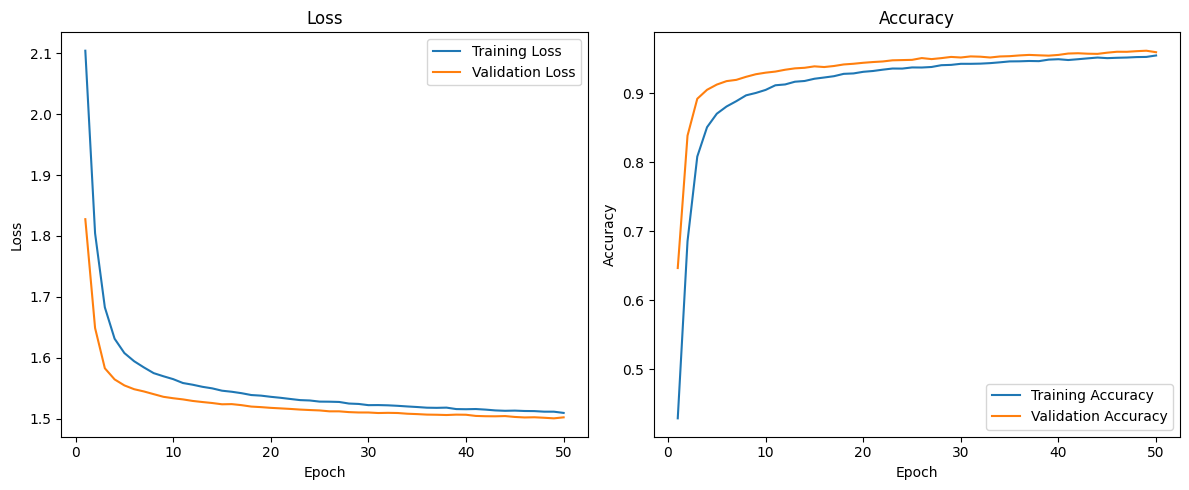

In [ ]:
matftorch.plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Train Set: Loss: 1.4985, Accuracy: 0.9635


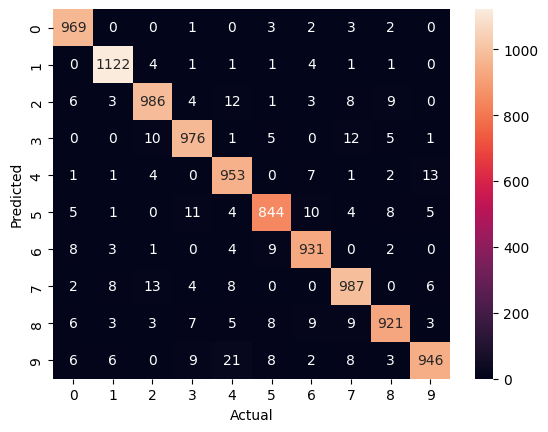

In [ ]:
test_loss, test_accuracy = matftorch.evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

Primetimo da je na ovaj način dobijena manja vrednost funkcije gubitka i nešto veća tačnost u odnosu na prethodni vid regularizacie.

# Analiza Prostora Gresaka

Videli smo da model daje dobru ocenu tačnosti. U praksi je značajno izdvojiti i instance na kojima model ne radi dobro u cilju boljeg razumevanja njegovog rada i budućih popravki.

Kreiraćemo prvo niz sa predikcijama modela.

In [ ]:
model.eval()
predicted_labels, true_labels = [], []
device = matftorch.get_device()

with torch.no_grad():  # No gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        predicted_labels.extend(predicted.squeeze().tolist())
        true_labels.extend(labels.tolist())

In [ ]:
len(predicted_labels), len(true_labels)

(10000, 10000)

Možemo nacrtati, na primer, prvih 20 instanci test skupa i obeležja koja im pridružuje klasifikator.

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [ ]:
device = get_device()
predicted_labels, true_labels = [], example_targets.tolist()

model.eval()
with torch.no_grad():
  inputs = example_data.to(device)
  outputs = model(inputs)
  predicted = torch.argmax(outputs, dim=1)
  predicted_labels.extend(predicted.squeeze().tolist())

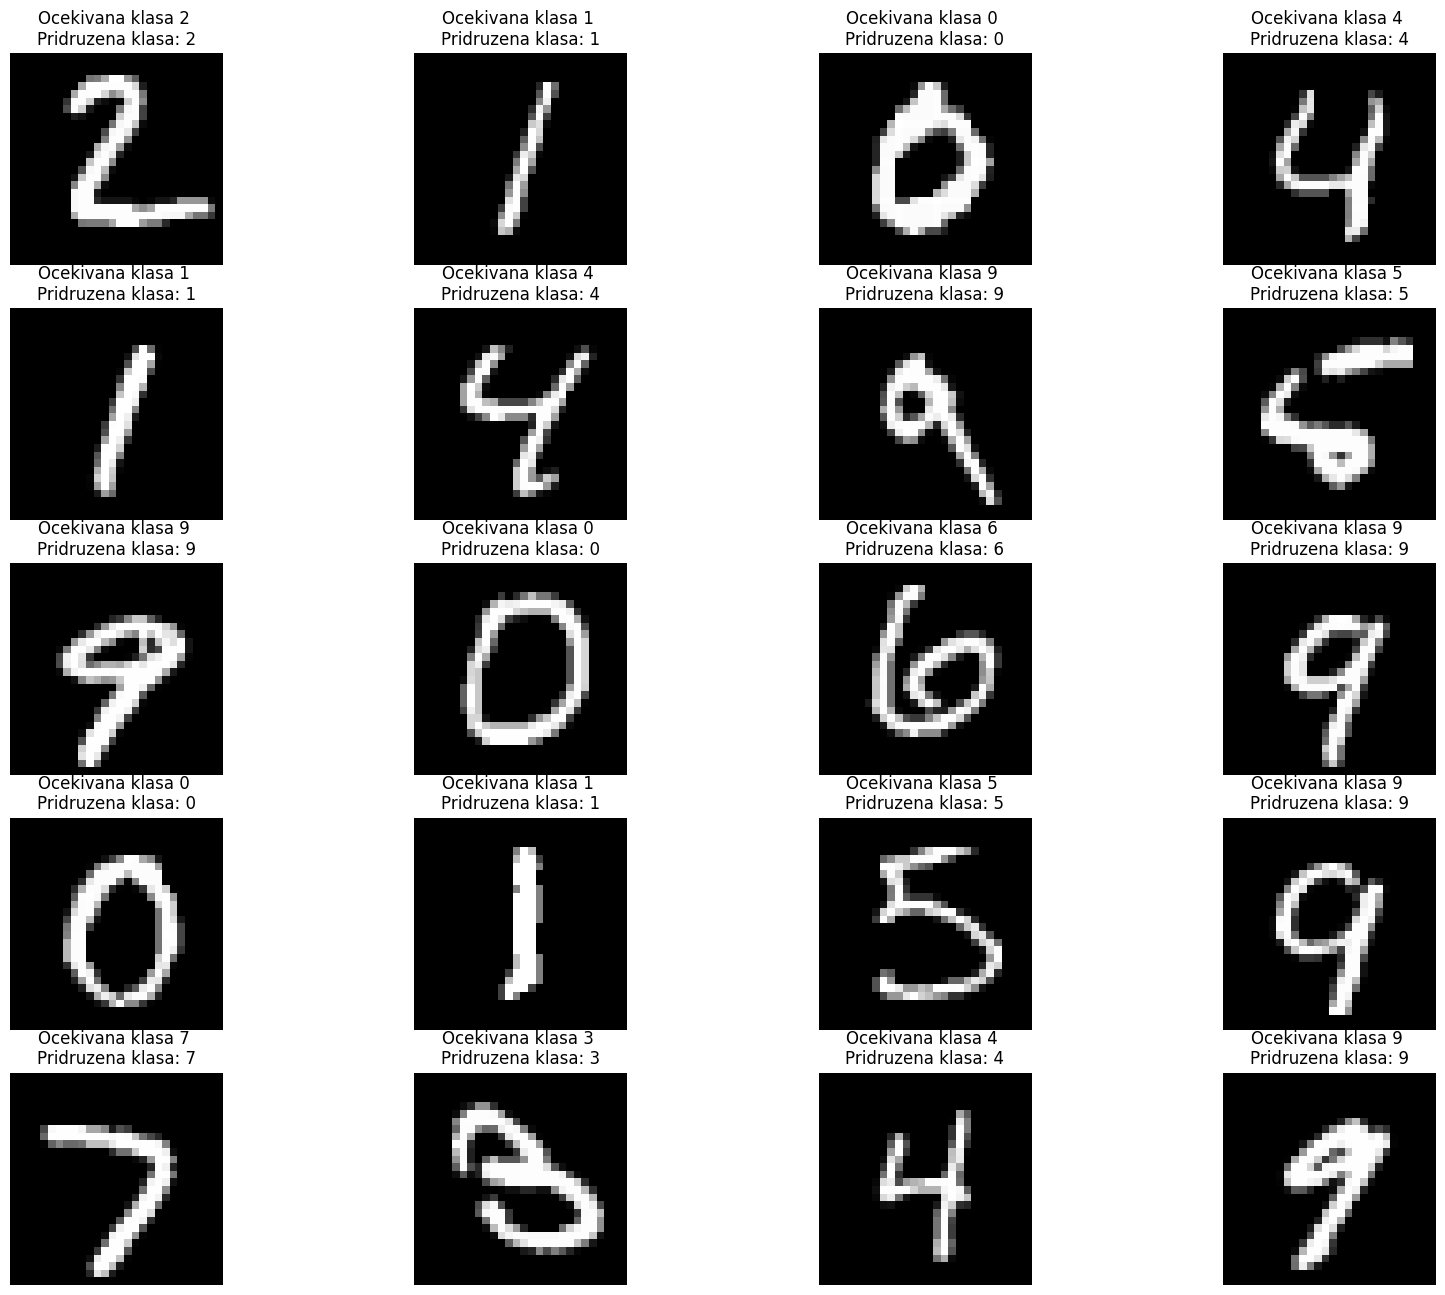

In [ ]:
fig = plt.figure(figsize=(20, 16))
image_size = 28
columns = 4
rows = 5

for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)

    img = example_data[i].reshape(image_size, image_size)

    true_label, predicted_label = true_labels[i], predicted_labels[i]
    plt.title('Ocekivana klasa {} \nPridruzena klasa: {}'.format(true_label, predicted_label))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

Vidimo da su sve izdvojene slike dobro klasifikovane.